In [1]:
import keras
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
def getstock(name):
    t = yf.Ticker(name)
    dat = t.history(period='max')
    return np.array(dat['Open'][-3900:])

In [3]:
yf.Ticker('AAPL').history(period='max')

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1980-12-12,0.41,0.41,0.41,0.41,117258400,0.0,0.0
1980-12-15,0.39,0.39,0.39,0.39,43971200,0.0,0.0
1980-12-16,0.36,0.36,0.36,0.36,26432000,0.0,0.0
1980-12-17,0.37,0.37,0.37,0.37,21610400,0.0,0.0
1980-12-18,0.38,0.38,0.38,0.38,18362400,0.0,0.0
...,...,...,...,...,...,...,...
2020-03-25,250.75,258.25,244.30,245.52,75900500,0.0,0.0
2020-03-26,246.52,258.68,246.36,258.44,63021800,0.0,0.0
2020-03-27,252.75,255.87,247.05,247.74,51054200,0.0,0.0


In [4]:
stocks = ['WMT', 'GOOG', 'DJI', '^GSPC', 'AAPL', 'MSFT', 'BRK-A', 'GE']

In [5]:
dat = np.array([getstock(n) for n in stocks])
dat.shape

(8, 3900)

In [6]:
window_width = 200

In [7]:
x = np.array([dat[:,i:i+window_width] / dat[:,i,None] for i in range(dat.shape[1] - window_width - 1)])
x.shape

(3699, 8, 200)

In [8]:
y = np.array([dat[:,i+window_width] / dat[:,i] for i in range(dat.shape[1] - window_width - 1)])
y.shape

(3699, 8)

In [10]:
model = keras.models.Sequential()
model.add(keras.layers.LSTM(50, activation='relu', input_shape=[x.shape[1], x.shape[2]]))
model.add(keras.layers.Dense(y.shape[1], activation='linear'))
model.compile(loss=keras.losses.mean_squared_error,
             optimizer=keras.optimizers.Nadam(learning_rate=0.001),
             metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 50)                50200     
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 408       
Total params: 50,608
Trainable params: 50,608
Non-trainable params: 0
_________________________________________________________________


In [11]:
history = model.fit(x, y, batch_size=64, epochs=60, verbose=0, validation_split=0.2)

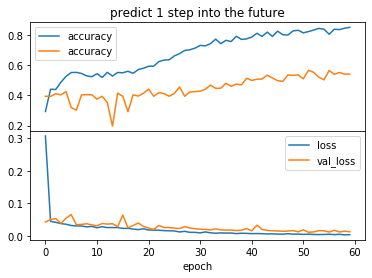

In [12]:
fig, (ax1, ax2) = plt.subplots(2, sharex=True)
fig.subplots_adjust(hspace=0)
ax1.title.set_text(f'predict 1 step into the future')

ax1.plot(history.history['accuracy'], label='accuracy')
ax1.plot(history.history['val_accuracy'], label='accuracy')
ax1.legend()

ax2.plot(history.history['loss'], label='loss')
ax2.plot(history.history['val_loss'], label='val_loss')
ax2.legend()

ax2.set_xlabel('epoch')
print()

In [13]:
model.evaluate(x, y, verbose=0)

[0.006092463173103127, 0.7915652990341187]

In [14]:
inp = x[-1].reshape((1, dat.shape[0], window_width))
p = model.predict(inp).reshape(dat.shape[0])
print('recent:     ', inp[0,:,-1])
print('expected:   ', y[-1])
print('prediction: ', p)

recent:      [1.0241838  1.03878594 0.82473673 0.8855362  1.31012855 1.16070063
 0.87166124 0.74418605]
expected:    [1.04046135 1.03820457 0.8417056  0.88661373 1.29970972 1.16597828
 0.877557   0.73062016]
prediction:  [0.90405166 1.0089569  1.0945449  0.83251995 1.2524935  1.0943172
 0.83454114 0.85771435]
